# 1. Sentiment analysis

Using the [Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/), we want to do a regression model that predict the ratings are on a 1-10 scale. You have an example train and test set in the `dataset` folder.

### 1.1 Regression Model

Use a feedforward neural network and NLP techniques we've seen up to now to train the best model you can on this dataset

### 1.2 RNN model

Train a RNN to do the sentiment analysis regression. The RNN should consist simply of an embedding layer (to make word IDs into word vectors) a recurrent blocks (GRU or LSTM) feeding into an output layer.

In [ ]:
#Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Q1: Regression model: Using the Dive into Deep Learning method with pytorch

In [ ]:
#reference material: https://machinelearningmastery.com/predict-sentiment-movie-reviews-using-deep-learning/

In [ ]:
#install d2l for for tokenization
!pip install d2l==0.16.3


     |████████████████████████████████| 81kB 5.3MB/s 


In [ ]:
#Import pytorch and neural network packages
import os
import torch
from torch import nn
import numpy as np
from d2l import torch as d2l

In [ ]:
#Load and save Stanford's Large Movie Review dataset
d2l.DATA_HUB['aclImdb'] = (
    'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz',
    '01ada507287d82875905620988597833ad4e0903')
data_dir = d2l.download_extract('aclImdb', 'aclImdb')

In [ ]:
#Read the training and test datasets
def read_imdb(data_dir, is_train):
    data, labels = [], []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test',
                                   label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    return data, labels

train_data = read_imdb(data_dir, is_train=True)
print('# trainings:', len(train_data[0]))
for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print('label:', y, 'review:', x[0:60])

# trainings: 25000
label: 1 review: Bizarre horror movie filled with famous faces but stolen by 
label: 1 review: Dear Readers,<br /><br />With High Expectations, Human Being
label: 1 review: This movie was excellent. A sad truth to how culture tends t


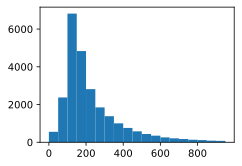

In [ ]:
#Using each word as a token, create a dict based on the training dataset
train_tokens = d2l.tokenize(train_data[0], token='word')
vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])

d2l.set_figsize()
d2l.plt.hist([len(line) for line in train_tokens], bins=range(0, 1000, 50));

In [ ]:
#Uniformize the length of comments to 500 chars
num_steps = 500 
train_features = np.array([
    d2l.truncate_pad(vocab[line], num_steps, vocab['<pad>'])
    for line in train_tokens])
print(train_features.shape)

(25000, 500)


In [ ]:
#Create a data iterator
train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])), 64)

In [ ]:
train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])), 64)

for X, y in train_iter:
    print('X:', X.shape, ', y:', y.shape)
    break
print('# batches:', len(train_iter))

X: (64, 500) , y: (64,)
# batches: 391


In [ ]:
#Create a function that loads the imdb data into d2l
def load_data_imdb(batch_size, num_steps=500):
    data_dir = d2l.download_extract('aclImdb', 'aclImdb')
    train_data = read_imdb(data_dir, True)
    test_data = read_imdb(data_dir, False)
    train_tokens = d2l.tokenize(train_data[0], token='word')
    test_tokens = d2l.tokenize(test_data[0], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor([
        d2l.truncate_pad(vocab[line], num_steps, vocab['<pad>'])
        for line in train_tokens])
    test_features = torch.tensor([
        d2l.truncate_pad(vocab[line], num_steps, vocab['<pad>'])
        for line in test_tokens])
    train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])),
                                batch_size)
    test_iter = d2l.load_array((test_features, torch.tensor(test_data[1])),
                               batch_size, is_train=False)
    return train_iter, test_iter, vocab

Sentiment analysis using RNN and pretrained GloVe vectors

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

In [ ]:
"""each word first obtains a feature vector from the embedding layer. 
Then, we further encode the feature sequence using a bidirectional recurrent neural network 
to obtain sequence information. Finally, we transform the encoded sequence information to output 
through the fully connected layer. Specifically, we can concatenate hidden states of bidirectional
 long-short term memory in the initial time step and final time step and pass it to the output 
 layer classification as encoded feature sequence information. In the BiRNN class implemented below,
  the Embedding instance is the embedding layer, the LSTM instance is the hidden layer
   for sequence encoding, and the Dense instance is the output layer for generated 
   classification results."""

class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set `bidirectional` to True to get a bidirectional recurrent neural
        # network
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                               bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # The shape of `inputs` is (batch size, no. of words). Because LSTM
        # needs to use sequence as the first dimension, the input is
        # transformed and the word feature is then extracted. The output shape
        # is (no. of words, batch size, word vector dimension).
        embeddings = self.embedding(inputs.T)
        # Since the input (embeddings) is the only argument passed into
        # nn.LSTM, both h_0 and c_0 default to zero.
        # we only use the hidden states of the last hidden layer
        # at different time step (outputs). The shape of `outputs` is
        # (no. of words, batch size, 2 * no. of hidden units).
        self.encoder.flatten_parameters()
        outputs, _ = self.encoder(embeddings)
        # Concatenate the hidden states of the initial time step and final
        # time step to use as the input of the fully connected layer. Its
        # shape is (batch size, 4 * no. of hidden units)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

In [ ]:
"""Create a bidirectional recurrent neural network with two hidden layers."""
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])

net.apply(init_weights);

In [ ]:
#Load pre-trained word vectors
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')

In [ ]:
#Query the word vectors in the IMDB vocab
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape

torch.Size([49346, 100])

In [ ]:
#Use the word vectors as feature vectors for each word
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

First run: 5 epochs Loss: 32% train acc: 86% test acc: 84%

loss 0.329, train acc 0.863, test acc 0.843
482.4 examples/sec on [device(type='cuda', index=0)]


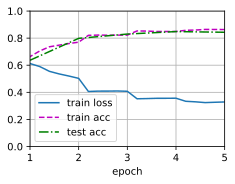

In [ ]:
#Train and evaluate the model using 5 epochs, then 50
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [ ]:
#Define the prediction function
def predict_sentiment(net, vocab, sentence):
    sentence = torch.tensor(vocab[sentence.split()], device=d2l.try_gpu())
    label = torch.argmax(net(sentence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'

In [ ]:
#use de trained model to classify sentences of 2 different sentiments
predict_sentiment(net, vocab, 'this movie is excellent')

'positive'

In [ ]:
predict_sentiment(net, vocab, 'this movie blows')
#As we can see, this incorrect

'positive'

In [ ]:
predict_sentiment(net, vocab, 'this movie is sweet')

'positive'

In [ ]:
predict_sentiment(net, vocab, 'this movie rocks')

'positive'

In [ ]:
predict_sentiment(net, vocab, 'this movie leaves to be desired')
#incorrect reading

'positive'

Second run: 50 epochs loss 0.518, train acc 0.749, test acc 0.736
This is much less acurate than the 50 epochs run

loss 0.518, train acc 0.749, test acc 0.736
481.0 examples/sec on [device(type='cuda', index=0)]


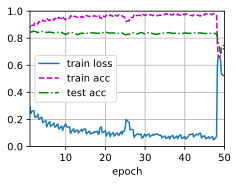

In [ ]:
#WIth 50 epochs instead
lr, num_epochs = 0.01, 50
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [ ]:
predict_sentiment(net, vocab, 'this movie is sweet')

'positive'

In [ ]:
predict_sentiment(net, vocab, 'this movie rocks')

'negative'

In [ ]:
predict_sentiment(net, vocab, 'this movie leaves to be desired')

'negative'

3rd run: 30 epochs loss nan, train acc 0.500, test acc 0.500
Again, overfitting



loss nan, train acc 0.500, test acc 0.500
481.3 examples/sec on [device(type='cuda', index=0)]


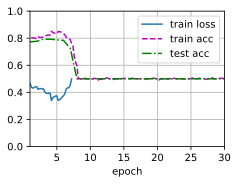

In [ ]:
#WIth 30 epochs instead
lr, num_epochs = 0.01, 30
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

# 2. (evil) XOR Problem

Train an LSTM to solve the XOR problem: that is, given a sequence of bits, determine its parity. The LSTM should consume the sequence, one bit at a time, and then output the correct answer at the sequence’s end. Test the two approaches below:

### 2.1 

Generate a dataset of random <=100,000 binary strings of equal length <= 50. Train the LSTM; what is the maximum length you can train up to with precisison?
    

### 2.2

Generate a dataset of random <=200,000 binary strings, where the length of each string is independently and randomly chosen between 1 and 50. Train the LSTM. Does it succeed? What explains the difference?


In [ ]:
#Install packages
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [ ]:
#Generate numpy data
def generateData(SeqCount=100000):#100,000 binary strings
    train_y = np.zeros((SeqCount, 2))
    seqs = np.random.choice(2, [SeqCount, 50]) #of equal length of 50
    for i,seq in enumerate(seqs):
        train_y[i][sum(seq)%2] = 1
    return seqs.reshape((SeqCount,50,1)), train_y

In [ ]:
train_x, train_y = generateData(SeqCount=100000)

In [ ]:
#define model, run with 200 epochs
Epoch 194/200
1563/1563 [==============================] - 7s 5ms/step - loss: 0.6921 - accuracy: 0.5111
#Around 19 epochs, accuracy starts jittering. The accuracy rate then is at .5026 bu a rate of +/- .002.d
#

model = Sequential() 
batch_size, timesteps, data_dim = None, None, 1
model.add(LSTM(10, return_sequences=False, stateful=False,
               batch_input_shape=(batch_size, timesteps, data_dim)))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(train_x, train_y, batch_size=64, epochs=200)

Epoch 1/200
1563/1563 [==============================] - 39s 4ms/step - loss: 0.6948 - accuracy: 0.5002
Epoch 2/200
1563/1563 [==============================] - 7s 4ms/step - loss: 0.6932 - accuracy: 0.5005
Epoch 3/200
1563/1563 [==============================] - 7s 4ms/step - loss: 0.6932 - accuracy: 0.4977
Epoch 4/200
1563/1563 [==============================] - 7s 4ms/step - loss: 0.6932 - accuracy: 0.4975
Epoch 5/200
1563/1563 [==============================] - 7s 4ms/step - loss: 0.6932 - accuracy: 0.4991
Epoch 6/200
1563/1563 [==============================] - 7s 4ms/step - loss: 0.6932 - accuracy: 0.5021
Epoch 7/200
1563/1563 [==============================] - 7s 4ms/step - loss: 0.6931 - accuracy: 0.5054
Epoch 8/200
1563/1563 [==============================] - 7s 4ms/step - loss: 0.6932 - accuracy: 0.4982
Epoch 9/200
1563/1563 [==============================] - 7s 5ms/step - loss: 0.6932 - accuracy: 0.5029
Epoch 10/200
1563/1563 [==============================] - 7s 5ms/step - 

In [ ]:
#running with 50 epochs to see what happens
#There is less jitter but no significant gain in accuracy

model = Sequential() 
batch_size, timesteps, data_dim = None, None, 1
model.add(LSTM(10, return_sequences=False, stateful=False,
               batch_input_shape=(batch_size, timesteps, data_dim)))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(train_x, train_y, batch_size=64, epochs=50)

Epoch 1/50
1563/1563 [==============================] - 9s 5ms/step - loss: 0.6933 - accuracy: 0.5036
Epoch 2/50
1563/1563 [==============================] - 7s 5ms/step - loss: 0.6933 - accuracy: 0.4995
Epoch 3/50
1563/1563 [==============================] - 7s 5ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 4/50
1563/1563 [==============================] - 8s 5ms/step - loss: 0.6932 - accuracy: 0.5031
Epoch 5/50
1563/1563 [==============================] - 7s 5ms/step - loss: 0.6932 - accuracy: 0.4988
Epoch 6/50
1563/1563 [==============================] - 7s 5ms/step - loss: 0.6932 - accuracy: 0.5010
Epoch 7/50
1563/1563 [==============================] - 7s 5ms/step - loss: 0.6932 - accuracy: 0.5036
Epoch 8/50
1563/1563 [==============================] - 7s 5ms/step - loss: 0.6932 - accuracy: 0.5021
Epoch 9/50
1563/1563 [==============================] - 7s 5ms/step - loss: 0.6932 - accuracy: 0.4995
Epoch 10/50
1563/1563 [==============================] - 7s 5ms/step - loss: 0.693

5.5.2.2 Running LSTM with <=200,000 binary strings, where the length of each string is independently and randomly chosen between 1 and 50

In [ ]:
import tensorflow as tf
import numpy as np
import copy
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [ ]:
def train_generator(seqCount=200000, order='Random', maxSeqLen = 50):
    train = {}
    arr = 1+np.array(range(maxSeqLen))
    if order=='Random':
        np.random.shuffle(arr)
    elif order=='Descending':
        arr = np.flip(arr)
    for i in range(maxSeqLen):
        train[i+1] = []
    for i in range(seqCount):
        seq = np.random.choice(2, [1, 1+int(np.floor(np.random.rand()*(maxSeqLen)))])[0]
        y = np.zeros(2)
        y[sum(seq)%2] = 1
        train[len(seq)].append(np.asarray([seq, y]))
    for i in arr:
        itrain = np.swapaxes(np.asarray(train[i]), 0, 1)
        train_x = itrain[0]
        train_y = itrain[1]
        yield np.asarray(list(train_x)).reshape((len(train_x), i, 1)), np.asarray(list(train_y)).reshape((len(train_y), 2))

In [ ]:
model = Sequential() 
batch_size, timesteps, data_dim = None, None, 1
model.add(LSTM(10, return_sequences=False, stateful=False,
               batch_input_shape=(batch_size, timesteps, data_dim)))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [ ]:

model1 = copy.copy(model)
for i in range(10):
    print("Times:", i)
    [model1.fit(train_x, train_y, batch_size=64, epochs=3) for train_x, train_y in train_generator(seqCount=100000, order='Random')]

Times: 0


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Epoch 1/3
31/31 [==============================] - 1s 4ms/step - loss: 0.6933 - accuracy: 0.5101
Epoch 2/3
31/31 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5095
Epoch 3/3
31/31 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5026
Epoch 1/3
32/32 [==============================] - 1s 4ms/step - loss: 0.6932 - accuracy: 0.4886
Epoch 2/3
32/32 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5114
Epoch 3/3
32/32 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5114
Epoch 1/3
31/31 [==============================] - 1s 5ms/step - loss: 0.6935 - accuracy: 0.5058
Epoch 2/3
31/31 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.5155
Epoch 3/3
31/31 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.5155
Epoch 1/3
32/32 [==============================] - 0s 4ms/step - loss: 0.6946 - accuracy: 0.4616
Epoch 2/3
32/32 [=============